##**Investigating Public Perception of ChatGPT: A Twitter Sentiment Analysis**

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from PIL import Image
import re
import pickle
import nltk
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim import corpora
from tqdm.auto import tqdm
#Transformer libraries
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

In [2]:
!pip install nltk

In [3]:
pip install transformers

In [4]:
#download tools
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
#Text cleaning functions
def remove_links(tweet):
    return re.sub("(http[s]?:\S+)","", tweet)

def remove_shortwords(tweet):
    tweet=re.sub("'", "", tweet)
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if  len(word) > 1]
    return " ".join(clean_tweet)


def remove_mentions(tweet):
    '''@User Mention'''
    return re.sub("@[A-Za-z0-9_]+","", tweet)


def remove_stopwords(tweet):
    stopwords_list = stopwords.words('english')
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if (word not in stopwords_list)]
    return " ".join(clean_tweet)

def remove_nonwords(tweet):
    tweet = re.sub('[^\w]',' ',tweet)
    return tweet

def clean_text(tweet):
    tweet = remove_links(tweet)
    tweet = remove_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_stopwords(tweet)
    tweet = remove_nonwords(tweet)
    tweet = remove_shortwords(tweet)
    tweet = tweet.strip()
    return tweet

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT.csv')


<ipython-input-6-ac84b321b397>:1: DtypeWarning: Columns (0,6,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT.csv')


In [7]:
df.head(10)

,Unnamed: 0,Date,Tweet,Url,User,UserCreated,UserVerified,UserFollowers,UserFriends,Retweets,Likes,Location,Description
0,0,2023-04-08 03:33:13+00:00,#ChatGPT If only there were a movie or somethi...,https://twitter.com/kirbydjohnson/status/16445...,kirbydjohnson,2012-07-29 22:57:46+00:00,False,50.0,76.0,0.0,0,NaN,NaN
1,1,2023-04-08 03:32:16+00:00,"Workshop Description: In this workshop, you wi...",https://twitter.com/UniversityWeb/status/16445...,UniversityWeb,2013-01-13 20:18:16+00:00,False,9056.0,387.0,0.0,0,NaN,"University webinars, speech videos, & news for..."
2,2,2023-04-08 03:32:05+00:00,New Post at AiNewsDrop!\n\nChatGPT is a doctor...,https://twitter.com/AiNewsDrop/status/16445436...,AiNewsDrop,2022-01-19 06:25:45+00:00,False,276.0,313.0,0.0,0,NaN,I'm up almost 24/7 hunting for AI News\n\nWith...
3,3,2023-04-08 03:31:08+00:00,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,https://twitter.com/tubeblogger/status/1644543...,tubeblogger,2013-06-25 01:42:59+00:00,False,312.0,293.0,0.0,0,The Internet,"Exploring the Best Of The Web. Tech, Games, Ar..."
4,4,2023-04-08 03:30:51+00:00,"""Classical art"" is struggling - not changed th...",https://twitter.com/majorradic/status/16445432...,majorradic,2011-12-12 01:29:15+00:00,False,522.0,684.0,0.0,2,Beograd Navodni,Mediji i milosrdje\n\n ...
5,5,2023-04-08 03:30:00+00:00,Alibaba invites businesses to trial 'ChatGPT r...,https://twitter.com/gadgetsnow/status/16445430...,gadgetsnow,2010-07-29 10:32:28+00:00,True,90392.0,56.0,0.0,0,New Delhi,The official technology news website of The Ti...
6,6,2023-04-08 03:28:59+00:00,Trying to stop students from using #AI and #ch...,https://twitter.com/Sherab_Taye/status/1644542...,Sherab_Taye,2010-05-10 12:40:40+00:00,False,338.0,53.0,0.0,0,World,Musician // Thinker // Metaphysical Dandy // f...
7,7,2023-04-08 03:28:31+00:00,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,https://twitter.com/cryptoccentral/status/1644...,cryptoccentral,2023-01-27 00:12:12+00:00,False,1.0,2.0,0.0,2,United States,Get the latest updates and insights on the cry...
8,8,2023-04-08 03:26:16+00:00,Gugenka team has created a fun Customize new p...,https://twitter.com/kiradragonp/status/1644542...,kiradragonp,2010-07-03 19:13:52+00:00,False,895.0,635.0,0.0,1,Canada,"Mad Scientist,Overseas Partnership,Tech Direct..."
9,9,2023-04-08 03:23:05+00:00,https://t.co/cDAXMevBtr\nThe race to develop #...,https://twitter.com/CDOTrends/status/164454134...,CDOTrends,2018-03-10 10:19:45+00:00,False,1051.0,2439.0,0.0,1,Hong Kong,Today's insights for digital leaders of tomorr...


In [7]:
#remove null values
df.isnull().sum()

Unnamed: 0           38
Date                 18
Tweet                52
Url                  81
User                 81
UserCreated          81
UserVerified         81
UserFollowers        81
UserFriends          81
Retweets            107
Likes                81
Location         119511
Description       22963
dtype: int64

In [8]:
df=df.dropna()

In [9]:
#remove duplications
df.duplicated().sum()

0

In [10]:
len(df)

351089

In [11]:
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

In [12]:
df.columns

Index(['index', 'Date', 'Tweet', 'Url', 'User', 'UserCreated', 'UserVerified',
       'UserFollowers', 'UserFriends', 'Retweets', 'Likes', 'Location',
       'Description'],
      dtype='object')

In [13]:
# Convert the 'date' column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])


In [14]:
# Extract the date component and assign it to the 'date' column
df['Date'] = df['Date'].dt.date
# Again convert this extraced date component to datetime object
df['Date'] = pd.to_datetime(df['Date'])


In [15]:
df_tweets= df['Tweet']

In [16]:
df_tweets = df_tweets.apply(clean_text)

In [17]:
df['c_tweets']= df_tweets

In [18]:
df = df.drop(['UserCreated','Url','UserVerified','UserFollowers','UserFriends'], axis=1)

In [19]:
df.head()

,index,Date,Tweet,User,Retweets,Likes,Location,Description,c_tweets
3,3,2023-04-08,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,tubeblogger,0.0,0,The Internet,"Exploring the Best Of The Web. Tech, Games, Ar...",openai gpt got supercharged ai chatgpt
4,4,2023-04-08,"""Classical art"" is struggling - not changed th...",majorradic,0.0,2,Beograd Navodni,Mediji i milosrdje\n\n ...,classical art struggling changed fact disappea...
5,5,2023-04-08,Alibaba invites businesses to trial 'ChatGPT r...,gadgetsnow,0.0,0,New Delhi,The official technology news website of The Ti...,alibaba invites businesses trial chatgpt rival...
6,6,2023-04-08,Trying to stop students from using #AI and #ch...,Sherab_Taye,0.0,0,World,Musician // Thinker // Metaphysical Dandy // f...,trying stop students using ai chatgpt like try...
7,7,2023-04-08,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,cryptoccentral,0.0,2,United States,Get the latest updates and insights on the cry...,asked chatgpt ai chatbot earn crypto trading a...


In [38]:
pd.set_option("max_colwidth", 200)

In [20]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

###1. Sentiment analysis with roBERTa model

In [23]:
# model, tokenizer and so on are located in the following repo
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

# a function that takes text and model to calculate probability of each sentiment
def sentiment_analyzer(text, model):

    encoded_input = tokenizer(text, return_tensors="pt")
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = np.round(softmax(scores), 2)
    scores_dict = {"neg": scores[0], "neu": scores[1], "pos": scores[2]}
    return scores_dict

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
# Calculate the size of each chunk
chunk_size = 10000

# Split the DataFrame into 4 chunks
chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]


In [61]:
df1=chunks[0]

In [62]:
len(df1)

10000

In [63]:
%%time
# apply the roberta function
df["probabilities"] = df1["c_tweets"].apply(
    sentiment_analyzer, model=roberta_model
)

CPU times: user 48min 16s, sys: 6.37 s, total: 48min 22s
Wall time: 12min 4s


In [78]:
df.head(20000)

,index,Date,Tweet,User,Retweets,Likes,Location,Description,c_tweets,0,roberta_polarity,roberta_sentiment,vader_polarity,vader_sentiment,prob_0
3,3,2023-04-08,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,tubeblogger,0.0,0,The Internet,"Exploring the Best Of The Web. Tech, Games, Ar...",openai gpt got supercharged ai chatgpt,NaN,0.522665,Positive,0.0000,Neutral,NaN
4,4,2023-04-08,"""Classical art"" is struggling - not changed th...",majorradic,0.0,2,Beograd Navodni,Mediji i milosrdje\n\n ...,classical art struggling changed fact disappea...,NaN,0.079830,Neutral,-0.2500,Negative,NaN
5,5,2023-04-08,Alibaba invites businesses to trial 'ChatGPT r...,gadgetsnow,0.0,0,New Delhi,The official technology news website of The Ti...,alibaba invites businesses trial chatgpt rival...,NaN,0.039979,Neutral,0.0000,Neutral,NaN
6,6,2023-04-08,Trying to stop students from using #AI and #ch...,Sherab_Taye,0.0,0,World,Musician // Thinker // Metaphysical Dandy // f...,trying stop students using ai chatgpt like try...,NaN,-0.421899,Negative,-0.2263,Neutral,NaN
7,7,2023-04-08,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,cryptoccentral,0.0,2,United States,Get the latest updates and insights on the cry...,asked chatgpt ai chatbot earn crypto trading a...,NaN,0.049958,Neutral,0.0000,Neutral,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26708,26703,2023-04-01,Budgeting tips from Chat GPT\n#ChatGPT #chatgp...,checkbook_app,0.0,0,"New York, USA",Manage your finances with ease! Checkbook Regi...,budgeting tips chat gpt chatgpt chatgpt4 gpt4 ...,NaN,NaN,NaN,0.0000,Neutral,NaN
26709,26704,2023-04-01,Italy's data protection watchdog on Friday iss...,WorldTimesWT,9.0,25,Worldwide,"Covering International affairs, Politics, Glob...",italy data protection watchdog friday issued i...,NaN,NaN,NaN,-0.2732,Negative,NaN
26711,26706,2023-04-01,So I finally got to play with #ChatGPT. I aske...,ConstantRebel55,0.0,4,"Atlanta, Georgia","Technologist, musician, polymath, INF(T)P | Po...",finally got play chatgpt asked believed sentie...,NaN,NaN,NaN,0.3182,Positive,NaN
26712,26707,2023-04-01,#Futurist Gerd Leonhard Discusses AI’s Impact...,gleonhard,3.0,1,"Zurich, Switzerland",Futurist Humanist Keynote Speaker: https://t.c...,futurist gerd leonhard discusses ai impact ind...,NaN,NaN,NaN,0.0000,Neutral,NaN


In [ ]:
# let's convert each probaility into separate column
probabilities = df["probabilities"].apply(pd.Series)

In [71]:
# Rename the columns in 'probabilities' to ensure no overlap
probabilities.columns = ['prob_' + str(col) for col in probabilities.columns]

# Now join the DataFrames; there should be no conflict
df = df.join(probabilities)

In [73]:
df = df.drop("probabilities", axis=1)

In [75]:
#  assign labels for each text, depending on the polarity, e.g. -1.0 until -0.25 negavite
polarity_weights = torch.tensor([-1, 0, 1])
probs = torch.tensor(df[["prob_neg", "prob_neu", "prob_pos"]].values)
polarity = polarity_weights * probs
polarity = polarity.sum(dim=-1)
polarity_scaled = nn.Tanh()(polarity)
df["roberta_polarity"] = polarity_scaled.numpy()
df["roberta_sentiment"] = pd.cut(
    df["roberta_polarity"],
    bins=[-1.0, -0.25, 0.25, 1.0],
    labels=["Negative", "Neutral", "Positive"],
)
df = df.drop(["prob_neg", "prob_neu", "prob_pos"], axis=1)

###2. Sentiment analysis with VADER model

In [41]:
%%time
# Initialize the VADER sentiment analyzer
vader_model = SentimentIntensityAnalyzer()
# apply VADER model to the dataset
df["vader_scores"] = df["c_tweets"].apply(
    lambda text: vader_model.polarity_scores(text)
)
print(f"Number of rows: {len(df)}")


Number of rows: 351089
CPU times: user 1min 3s, sys: 194 ms, total: 1min 3s
Wall time: 1min 3s


In [42]:
# assign labels for each text as we did for Roberta model, depending on the polarity, e.g. -1.0 until -0.25 negavite
df["vader_polarity"] = df["vader_scores"].apply(
    lambda score_dict: score_dict["compound"]
)

df["vader_sentiment"] = pd.cut(
    df["vader_polarity"],
    bins=[-1.0, -0.25, 0.25, 1.0],
    labels=["Negative", "Neutral", "Positive"],
)
df = df.drop(["vader_scores"], axis=1)

### Plotting 2 models

<ipython-input-79-93e5fdc0e975>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["roberta_polarity"], color="r", shade=True, legend="roberta_polarity")
<ipython-input-79-93e5fdc0e975>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["vader_polarity"], color="b", shade=True, legend="vader_polaroty")


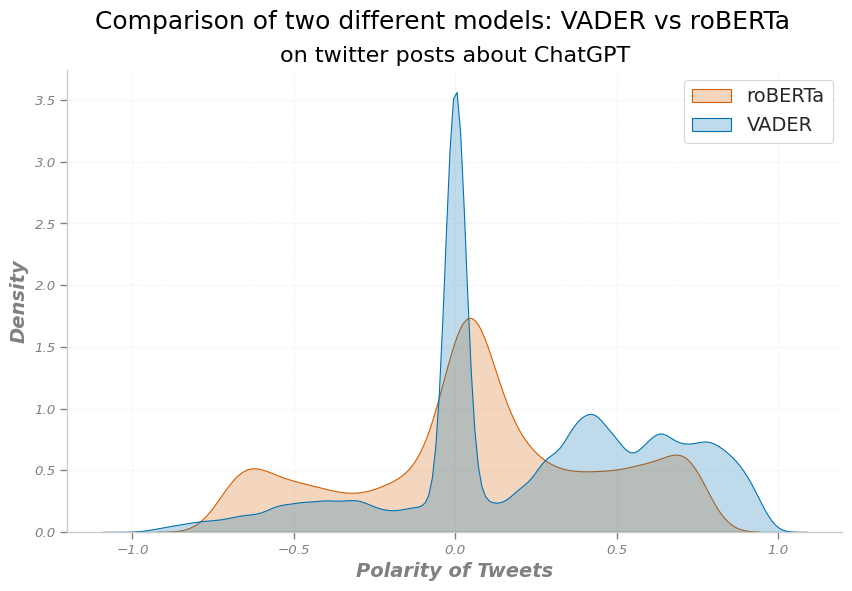

In [79]:
# Plotting the KDE Plot
fig = plt.figure(figsize=(10, 6))
sns.set("paper", "whitegrid", "colorblind")
sns.kdeplot(df["roberta_polarity"], color="r", shade=True, legend="roberta_polarity")
sns.kdeplot(df["vader_polarity"], color="b", shade=True, legend="vader_polaroty")
sns.despine(right=True, top=True)
plt.tick_params(
    reset=True,
    top=False,
    right=False,
    color="gray",
    labelcolor="gray",
    grid_alpha=0.2,
    grid_linestyle="--",
)
plt.xticks(**{"fontsize": 14, "font": "Arial", "fontstyle": "italic"})
plt.yticks(**{"fontsize": 14, "font": "Arial", "fontstyle": "italic"})
plt.xlabel(
    "Polarity of Tweets",
    font="Arial",
    fontstyle="italic",
    weight="bold",
    fontsize=14,
    color="gray",
)
plt.ylabel(
    "Density",
    font="Arial",
    fontstyle="italic",
    weight="bold",
    fontsize=14,
    color="gray",
)
plt.legend(["roBERTa", "VADER"], bbox_to_anchor=(1, 1.0), fontsize=14)
plt.suptitle(
    "Comparison of two different models: VADER vs roBERTa",
    fontsize=18,
    color="black",
)
plt.title(
    "on twitter posts about ChatGPT",
    fontsize=16,
    color="black",
)
plt.show()

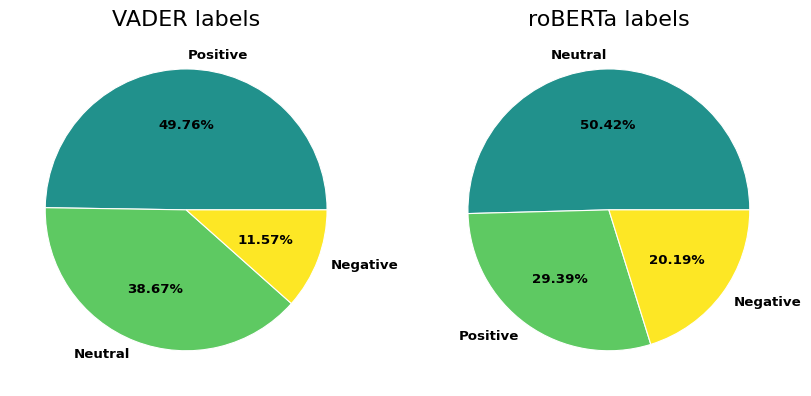

In [80]:
# creating a pie plots for count of sentiment labels
plt.figure(figsize=(10, 6))
plt.subplot(121)
df["vader_sentiment"].value_counts(normalize=True).to_frame().plot(
    ax=plt.gca(),
    kind="pie",
    autopct="%.2f%%",
    y="vader_sentiment",
    colors=['#21918c', '#5ec962', '#fde725'],
    **{
        "textprops": {
            "fontsize": 14,
            "font": "Arial",

            "weight": "bold",
            "color": "black",
        }
    }
)
plt.legend().remove()
plt.title(
    "VADER labels",
    fontsize=16,
    color="black",
)
plt.ylabel("")

# create the second pie plot
plt.subplot(122)
df["roberta_sentiment"].value_counts(normalize=True).to_frame().plot(
    ax=plt.gca(),
    kind="pie",
    autopct="%.2f%%",
    y="roberta_sentiment",
    # figsize=(5, 6),
    colors=['#21918c', '#5ec962', '#fde725'],
    **{
        "textprops": {
            "fontsize": 14,
            "font": "Arial",
            "weight": "bold",
            "color": "black",
        }
    }
)
plt.legend().remove()
plt.title(
    "roBERTa labels",
    fontsize=16,
    color="black",
)
plt.ylabel("")
plt.show()

In [90]:
df.head(10)

,index,Date,Tweet,User,Retweets,Likes,Location,Description,c_tweets,0,roberta_polarity,roberta_sentiment,vader_polarity,vader_sentiment,prob_0,tokens
3,3,2023-04-08,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,tubeblogger,0.0,0,The Internet,"Exploring the Best Of The Web. Tech, Games, Ar...",openai gpt got supercharged ai chatgpt,NaN,0.522665,Positive,0.0000,Neutral,NaN,openai gpt got supercharged ai chatgpt
4,4,2023-04-08,"""Classical art"" is struggling - not changed th...",majorradic,0.0,2,Beograd Navodni,Mediji i milosrdje\n\n ...,classical art struggling changed fact disappea...,NaN,0.079830,Neutral,-0.2500,Negative,NaN,classical art struggling changed fact disappea...
5,5,2023-04-08,Alibaba invites businesses to trial 'ChatGPT r...,gadgetsnow,0.0,0,New Delhi,The official technology news website of The Ti...,alibaba invites businesses trial chatgpt rival...,NaN,0.039979,Neutral,0.0000,Neutral,NaN,alibaba invites businesses trial chatgpt rival...
6,6,2023-04-08,Trying to stop students from using #AI and #ch...,Sherab_Taye,0.0,0,World,Musician // Thinker // Metaphysical Dandy // f...,trying stop students using ai chatgpt like try...,NaN,-0.421899,Negative,-0.2263,Neutral,NaN,trying stop students using ai chatgpt like try...
7,7,2023-04-08,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,cryptoccentral,0.0,2,United States,Get the latest updates and insights on the cry...,asked chatgpt ai chatbot earn crypto trading a...,NaN,0.049958,Neutral,0.0000,Neutral,NaN,asked chatgpt ai chatbot earn crypto trading a...
8,8,2023-04-08,Gugenka team has created a fun Customize new p...,kiradragonp,0.0,1,Canada,"Mad Scientist,Overseas Partnership,Tech Direct...",gugenka team created fun customize new plugin ...,NaN,0.604368,Positive,0.7906,Positive,NaN,gugenka team created fun customize new plugin ...
9,9,2023-04-08,https://t.co/cDAXMevBtr\nThe race to develop #...,CDOTrends,0.0,1,Hong Kong,Today's insights for digital leaders of tomorr...,race develop ai models instruction following c...,NaN,0.148885,Neutral,0.0000,Neutral,NaN,race develop ai models instruction following c...
10,10,2023-04-08,Took ~90 minutes but I convinced #ChatGPT that...,tctimmeh,0.0,1,"Earth, probably",Free will is an illusion. No one is in control...,took 90 minutes convinced chatgpt there war cl...,NaN,-0.454216,Negative,0.1531,Neutral,NaN,took 90 minutes convinced chatgpt there war cl...
11,11,2023-04-08,"Share tweets with my free chat GPT, Telegram b...",xTweetsio,0.0,1,@nTweetbot,"Share tweets with my free chatGPT, Telegram bo...",share tweets free chat gpt telegram bot get in...,NaN,0.462117,Positive,0.9231,Positive,NaN,share tweets free chat gpt telegram bot get in...
12,12,2023-04-08,🚀 Discover the power of #ChatGPT with our begi...,yuhanito,0.0,0,"Manchester, UK",Adopting an Innovative Data-Driven Strategy to...,discover power chatgpt beginner friendly cours...,NaN,0.462117,Positive,0.7783,Positive,NaN,discover power chatgpt beginner friendly cours...


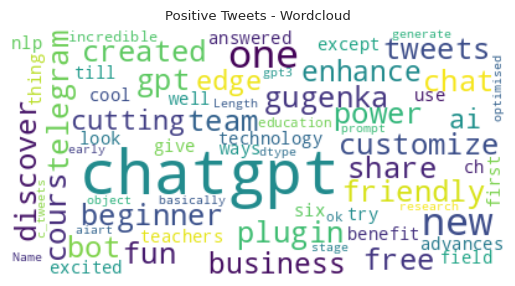

In [92]:
# Wordcloud with positive tweets
positive_tweets = df['c_tweets'][df["vader_sentiment"] == 'Positive']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


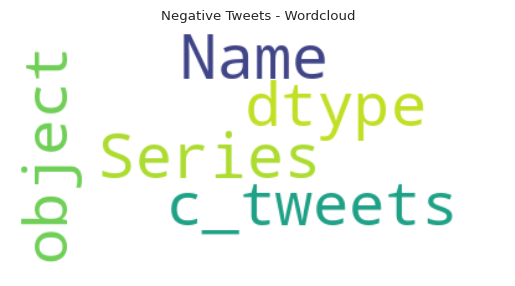

In [95]:
# Wordcloud with negative tweets
positive_tweets = df['c_tweets'][df["roberta_sentiment"] == 'Negative	']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

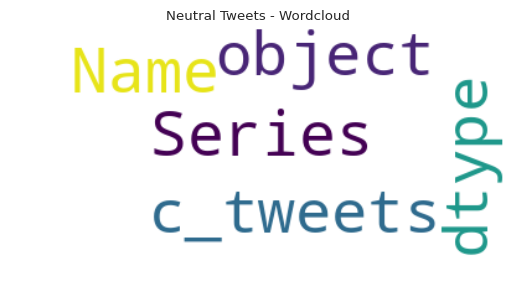

In [96]:
# Wordcloud with Neutral tweets
positive_tweets = df['c_tweets'][df["roberta_sentiment"] == 'Neutral		']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Neutral Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [97]:
# Dates with highest tweet counts
top_tweet_dates = df.groupby(pd.Grouper(key='Date', freq='D')).size().reset_index(name='Tweet').sort_values(by='Tweet', ascending=False)
print(top_tweet_dates)

          Date  Tweet
69  2023-02-07   6544
70  2023-02-08   5291
6   2022-12-06   4653
105 2023-03-15   4472
71  2023-02-09   4468
..         ...    ...
31  2022-12-31    902
32  2023-01-01    830
25  2022-12-25    747
129 2023-04-08    209
0   2022-11-30     64

[130 rows x 2 columns]


<ipython-input-98-0220d074b66c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tweets_by_day, x='Date', y='Tweet', palette='viridis')


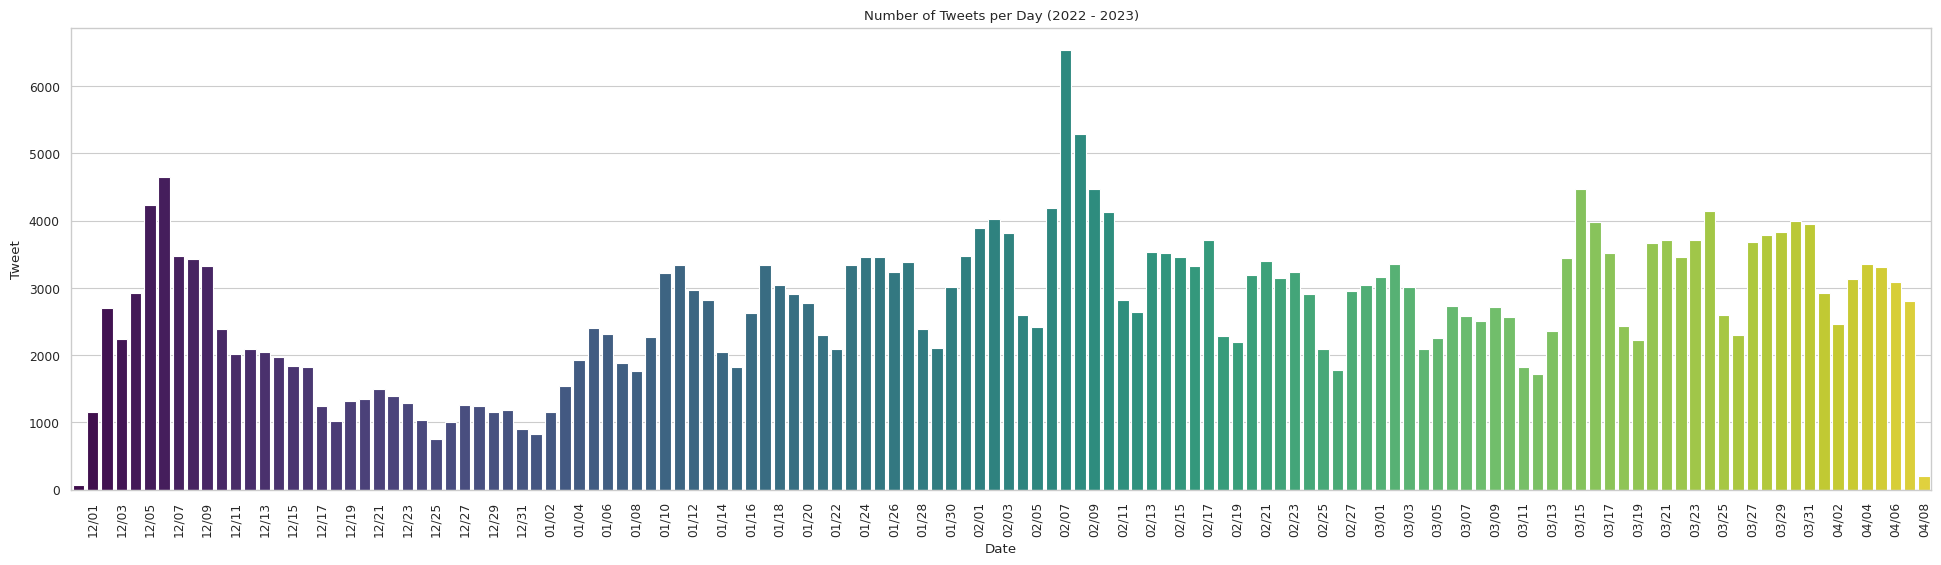

In [98]:
# Static Day
tweets_by_day = df.groupby(pd.Grouper(key='Date', freq='D')).size().reset_index()
tweets_by_day.columns = ['Date', 'Tweet']
tweets_by_day['Date'] = tweets_by_day['Date'].dt.strftime('%m/%d')
plt.figure(figsize=(24, 6))
sns.barplot(data=tweets_by_day, x='Date', y='Tweet', palette='viridis')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.title('Number of Tweets per Day (2022 - 2023)')
plt.xticks(rotation=90)
plt.show()

In [105]:
df.head()

,index,Date,Tweet,User,Retweets,Likes,Location,Description,c_tweets,0,roberta_polarity,roberta_sentiment,vader_polarity,vader_sentiment,prob_0,tokens
3,3,2023-04-08,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,tubeblogger,0.0,0,The Internet,"Exploring the Best Of The Web. Tech, Games, Ar...",openai gpt got supercharged ai chatgpt,NaN,0.522665,Positive,0.0000,Neutral,NaN,openai gpt got supercharged ai chatgpt
4,4,2023-04-08,"""Classical art"" is struggling - not changed th...",majorradic,0.0,2,Beograd Navodni,Mediji i milosrdje\n\n ...,classical art struggling changed fact disappea...,NaN,0.079830,Neutral,-0.2500,Negative,NaN,classical art struggling changed fact disappea...
5,5,2023-04-08,Alibaba invites businesses to trial 'ChatGPT r...,gadgetsnow,0.0,0,New Delhi,The official technology news website of The Ti...,alibaba invites businesses trial chatgpt rival...,NaN,0.039979,Neutral,0.0000,Neutral,NaN,alibaba invites businesses trial chatgpt rival...
6,6,2023-04-08,Trying to stop students from using #AI and #ch...,Sherab_Taye,0.0,0,World,Musician // Thinker // Metaphysical Dandy // f...,trying stop students using ai chatgpt like try...,NaN,-0.421899,Negative,-0.2263,Neutral,NaN,trying stop students using ai chatgpt like try...
7,7,2023-04-08,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,cryptoccentral,0.0,2,United States,Get the latest updates and insights on the cry...,asked chatgpt ai chatbot earn crypto trading a...,NaN,0.049958,Neutral,0.0000,Neutral,NaN,asked chatgpt ai chatbot earn crypto trading a...


In [107]:
df['Date'] = pd.to_datetime(df['Date'])

In [108]:
# Assuming 'df' is your DataFrame and it has a 'Date' and 'vader_sentiment' column
tweets_by_day_sentiment = df.groupby([df['Date'].dt.date, 'vader_sentiment']).size().reset_index(name='Tweet')

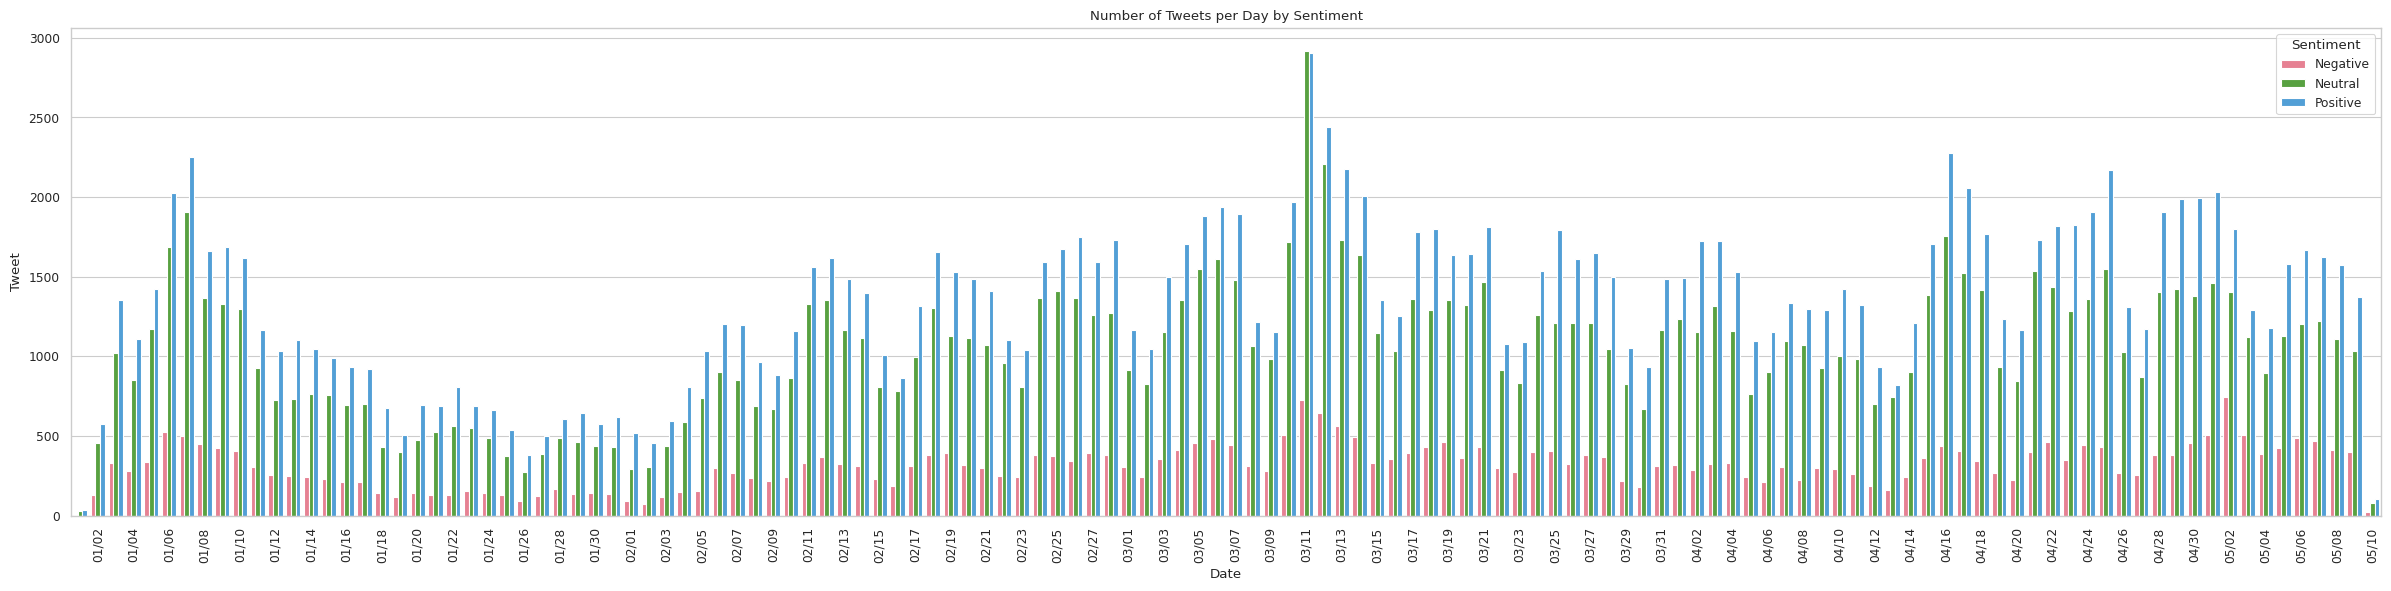

In [109]:
# Plotting
plt.figure(figsize=(24, 6))

# If you have more than two sentiments (e.g., 'neutral'), adjust the palette accordingly
palette = sns.color_palette("husl", tweets_by_day_sentiment['vader_sentiment'].nunique())

sns.barplot(data=tweets_by_day_sentiment, x='Date', y='Tweet', hue='vader_sentiment', palette=palette)

# Set major ticks format and use a locator to ensure dates don't overlap
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

plt.title('Number of Tweets per Day by Sentiment')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [59]:
df.to_csv('Robertaesult.csv', index=False)
from google.colab import files
# Download the file to your local machine
files.download('Robertaesult.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>